## Интеллектуальный анализ данных – весна 2024
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать со встроенным в `sklearn` набором данных `wine`, содержащим информацию о характеристиках трёх видов вина. Описание набора можно найти [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine) и [здесь](https://rdrr.io/cran/rattle.data/man/wine.html).

Загрузим набор данных и сохраним информацию о признаках в переменную `X`, а о зависимой переменной – в переменную `y`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_wine

data = load_wine()
X = pd.DataFrame(data['data'], columns = data['feature_names'])
y = data['target']
X.head(8)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0


**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные переменные? Если да, то закодируйте их при помощи OneHot-кодирования. Используйте [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

In [3]:
missing_values = X.isnull().sum().sum()
if missing_values > 0:
    X.dropna(inplace=True)
    print("Пропущенные значения есть и удалены.")
else:
    print("Пропущенных значений нет.")

Пропущенных значений нет.


In [4]:
from sklearn.preprocessing import OneHotEncoder

categorical_vars = X.select_dtypes(include=['object']).columns

if len(categorical_vars) > 0:
    print("Категориальные переменные:", categorical_vars)
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_vars]))
    X = pd.concat([X.drop(categorical_vars, axis=1), X_encoded], axis=1)
else:
    print("Категориальных переменных нет.")    

Категориальных переменных нет.


**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

Используйте аргумент `stratify` при разбиении. Почему это важно?

In [5]:
from sklearn.model_selection import train_test_split

np.random.seed(52)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

С помощью stratify мы сохраняем исходное распределение классов в обеих выборках. Это важно, потому что если мы не будем использовать stratify, то разбиение может привести к тому, что в тестовой выборке окажется слишком мало или слишком много представителей какого-то класса, что может привести к неправильной оценке качества модели.

**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака: `alcohol` и `magnesium` – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [7]:
from sklearn.metrics import accuracy_score

X_train_selected = X_train[['alcohol', 'magnesium']]
X_test_selected = X_test[['alcohol', 'magnesium']]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

train_scores = []
test_scores = []

n_neighbors = [1, 3, 5, 10, 15, 25]

for n in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train_scaled, y_train)
    
    train_pred = knn.predict(X_train_scaled)
    train_accuracy = accuracy_score(y_train, train_pred)
    train_scores.append(train_accuracy)
    
    test_pred = knn.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, test_pred)
    test_scores.append(test_accuracy)

print("NN\tTrain\tTest")
for i, n in enumerate(n_neighbors):
    print(f"{n}\t{train_scores[i]:.2f}\t{test_scores[i]:.2f}")

NN	Train	Test
1	1.00	0.59
3	0.85	0.65
5	0.84	0.63
10	0.75	0.69
15	0.73	0.70
25	0.69	0.72


**Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](http://rasbt.github.io/mlxtend/installation/).

In [8]:
!pip install mlxtend

Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

In [9]:
import mlxtend

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов.
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново.
6. Построение графика может занять некоторое время – придётся немного подождать!

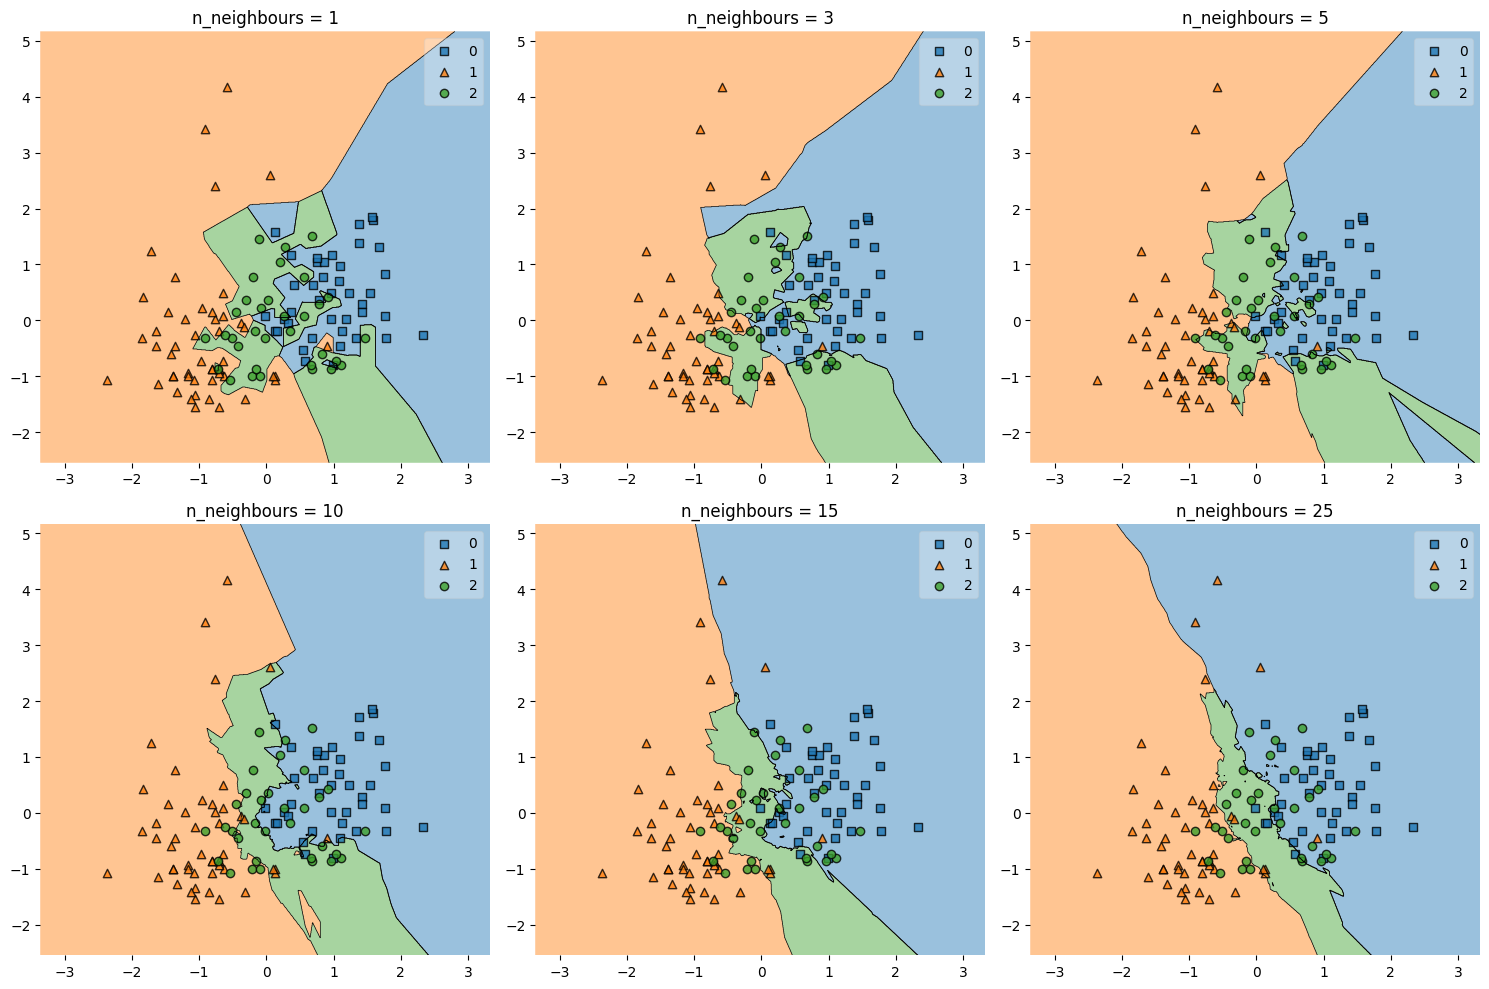

In [10]:
from mlxtend.plotting import plot_decision_regions

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

n_neighbors = [1, 3, 5, 10, 15, 25]

for i, n in enumerate(n_neighbors):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train_scaled, y_train)
    plot_decision_regions(X_train_scaled, y_train, clf=knn, ax=axs[i//3, i%3])
    axs[i//3, i%3].set_title(f"n_neighbours = {n}")

plt.tight_layout()
plt.show()

**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности. Какие из результатов явно говорят о переобучении модели? Почему?

Кажется, оптимально использовать число соседей, равное 10. Оно балансирует по точности между тренировочной и тестовой выборками и показывает, и при этом эта точность достаточно высокая.

У k = 1 явно наблюдается переобуение, так как точность на train равна 1, и на графике все слишком точно, а на тестовых данных точность очень низкая. У k = 3 и k = 5 переобучаемость не настолько большая, но она все еще есть, так как точность на train сильно выше, чем на test, и решающие поверхности выглядят слишком точными

В это время у числа соседей, равное 15 и 25, слишком низкая точность на обучаемой выборке, что говорит о недообучении, а на решающих поверхностях тоже точнь много ошибок

### Задание 2. KNN своими руками. 2 Балла

В данном задании мы попробуем реализовать алгоритм KNN своими руками. В данном случае мы попробуем сделать KNN для классификации.

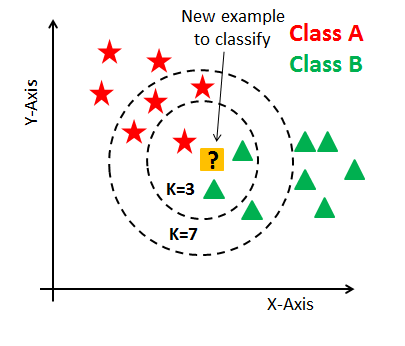

In [11]:
from collections import Counter

class KNN:
    def __init__(self, k:int):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        distances = self.count_distance(X, self.X_train)
        k_nearest_indices = np.argsort(distances)[:, :self.k]
        k_nearest_labels = self.y_train[k_nearest_indices]
        predictions = np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=1, arr=k_nearest_labels)
        return np.array(predictions)

    def count_distance(self, X1, X2):
        X1 = X1[:, np.newaxis, :]
        return np.linalg.norm(X1 - X2, axis=2)

In [12]:
# Не меняйте файл!
def test_knn(KNN):
  knn = KNN(k=1)
  X_train =  np.array([[1, 1], [2, 2]])
  y_train =  np.array([0, 1])
  X_test =  np.array([[1.5, 1.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [0]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[9.5, 9.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5.5, 5.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[15, 15]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5, 5], [2, 2]])
  knn.fit(X_train, y_train)
  assert all(knn.predict(X_test) == [1, 0])

In [13]:
# Если тесты эти пройдены, то все верно!
test_knn(KNN)

### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [14]:
import wget
wget.download('https://github.com/hse-ds/iad-intro-ds/raw/master/2024/homeworks/hw04_knn_linreg/diamonds.csv', 'diamonds.csv')
df = pd.read_csv('diamonds.csv')
df.head(5)

 28% [...............                                       ]  925696 / 3192560

 56% [..............................                        ] 1818624 / 3192560

 89% [................................................      ] 2859008 / 3192560

100% [......................................................] 3192560 / 3192560

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

**Задача 3.1 (0.2 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их.
Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

In [15]:
if df.isnull().values.any():
    df.dropna(inplace=True)
    print("Пропущенные значения были.")
else:
    print("Пропущенные значения отсутствуют.")

df.drop(columns=['Unnamed: 0'], inplace=True)
print("Бессмысленный столбец 'Unnamed: 0' удален.")

Пропущенные значения отсутствуют.
Бессмысленный столбец 'Unnamed: 0' удален.


**Задача 3.2 (0.1 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Выведите матрицу выборочных корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки коррелируют с целевой переменной больше всего?

In [16]:
numerical_features = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_features.corr()
target_correlations = correlation_matrix['price']
correlation_matrix

,carat,depth,table,price,x,y,z
carat,1.000000,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387
depth,0.028224,1.000000,-0.295779,-0.010647,-0.025289,-0.029341,0.094924
table,0.181618,-0.295779,1.000000,0.127134,0.195344,0.183760,0.150929
price,0.921591,-0.010647,0.127134,1.000000,0.884435,0.865421,0.861249
x,0.975094,-0.025289,0.195344,0.884435,1.000000,0.974701,0.970772
y,0.951722,-0.029341,0.183760,0.865421,0.974701,1.000000,0.952006
z,0.953387,0.094924,0.150929,0.861249,0.970772,0.952006,1.000000


In [17]:
target_correlations

carat    0.921591
depth   -0.010647
table    0.127134
price    1.000000
x        0.884435
y        0.865421
z        0.861249
Name: price, dtype: float64

Больше всего с целевой переменной коррелируют признаки 'carat', а далее идут 'x', 'y', 'z'

**Задача 3.3 (0.1 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные переменные при помощи OneHot-кодирования.

In [18]:
df_encoded = pd.get_dummies(df)
df_encoded.head()


,carat,depth,table,price,x,y,z,cut_Fair,cut_Good,cut_Ideal,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,0,1,0,...,0,1,0,0,0,1,0,0,0,0


**Задача 3.4 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3. Не забудьте про параметр `stratify`.

In [19]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop(columns=['price'])
y = df_encoded['price'] 
num_buckets = 25 #иначе stratify не сработает, потому что не будет достаточно значений нужного класса. 25 выбрал случайно
y_buckets = pd.qcut(y, num_buckets, labels=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y_buckets, random_state=52)

**Задача 3.5 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче масштабируйте вещественные признаки тренировочной и тестовой выборок при помощи модуля `StandardScaler`.

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Задача 3.6 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Среднеквадратичная ошибка на тренировочной выборке:", mse_train)
print("Среднеквадратичная ошибка на тестовой выборке:", mse_test)


Среднеквадратичная ошибка на тренировочной выборке: 1300524.0780810413
Среднеквадратичная ошибка на тестовой выборке: 1223799.338932834


**Задача 3.7 (0.2 балла)** Изучите [документацию](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [22]:
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})

pd.options.display.float_format = '{:.2f}'.format

coefficients

,Feature,Coefficient
0,carat,5340.31
1,depth,-82.85
2,table,-56.99
3,x,-1035.12
4,y,22.28
5,z,-141.85
6,cut_Fair,-115470867157162.14
7,cut_Good,-195764825507197.91
8,cut_Ideal,-334510528349923.69
9,cut_Premium,-298364878677661.56


Так хотелось сказать про 'clarity' и 'color', но это категориальные признаки. 

А среди вещественных переменных по модулю самые большие оценки коэффициентов у 'carat' и 'x'.

**Задача 3.8 (0.4 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом.

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \frac{1}{2}\alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией.

Обучите Lasso-регрессию и Ridge-регрессию, уставновив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [23]:
from sklearn.linear_model import Lasso, Ridge

lasso_model = Lasso(alpha=10)
lasso_model.fit(X_train_scaled, y_train)

coefficients_lasso = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient_Lasso': lasso_model.coef_
})

coefficients_lasso

,Feature,Coefficient_Lasso
0,carat,4858.60
1,depth,-46.26
2,table,-43.07
3,x,-539.75
4,y,-0.00
5,z,-158.76
6,cut_Fair,-132.90
7,cut_Good,-43.91
8,cut_Ideal,45.60
9,cut_Premium,0.00


In [24]:
ridge_model = Ridge(alpha=10)
ridge_model.fit(X_train_scaled, y_train)

coefficients_ridge = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient_Ridge': ridge_model.coef_
})

coefficients_ridge

,Feature,Coefficient_Ridge
0,carat,5295.07
1,depth,-77.10
2,table,-55.60
3,x,-982.84
4,y,22.55
5,z,-154.42
6,cut_Fair,-131.19
7,cut_Good,-42.98
8,cut_Ideal,55.29
9,cut_Premium,16.19


Оценки коэффициентов упали, у категориальных признаков - в миллионы раз, у вещественных параметров не так сильно, то тоже снизились, однако есть исключения: у Ridge-регрессии оценки коэффициентов у 'y' и 'z' больше, чем у обычной регрессии, у Lasso-регрессии выросла оценка коэффициента у 'z'.

Это говорит о том, что проблема мультиколлинеарности присутствовала, а для категориальных признаков она была огромной.

**Задача 3.9 (0.4 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов.

Какой метод агрессивнее уменьшает веса? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

/Users/andrewivanov/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.545e+08, tolerance: 6.002e+07
  model = cd_fast.enet_coordinate_descent(


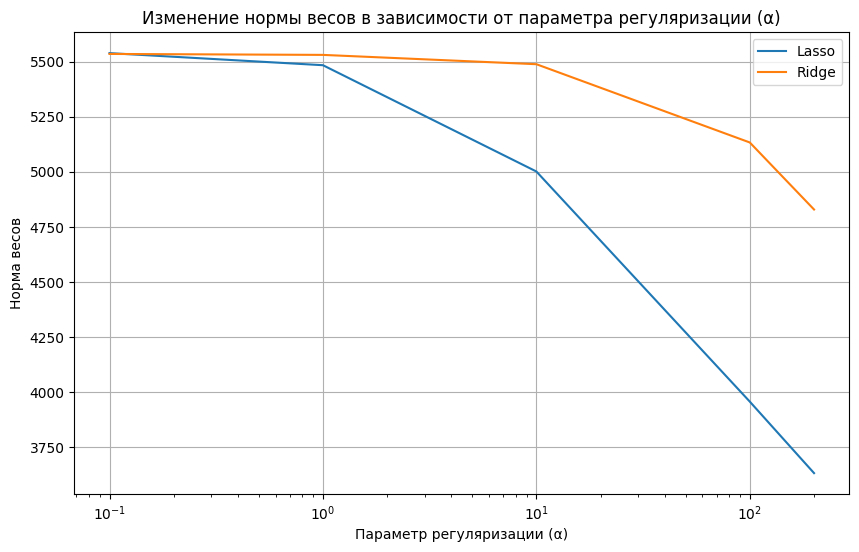

In [25]:
alphas = [0.1, 1, 10, 100, 200]
norms_lasso = []
norms_ridge = []

for alpha in alphas:
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X_train_scaled, y_train)
    norm_lasso = np.linalg.norm(lasso_model.coef_)
    norms_lasso.append(norm_lasso)
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train_scaled, y_train)
    norm_ridge = np.linalg.norm(ridge_model.coef_)
    norms_ridge.append(norm_ridge)

plt.figure(figsize=(10, 6))
plt.plot(alphas, norms_lasso, label='Lasso')
plt.plot(alphas, norms_ridge, label='Ridge')
plt.title('Изменение нормы весов в зависимости от параметра регуляризации (\u03B1)')
plt.xlabel('Параметр регуляризации (\u03B1)')
plt.ylabel('Норма весов')
plt.xscale('log') #так будет информативнее
plt.legend()
plt.grid(True)
plt.show()

**Задача 3.10 (0.5 балла)**
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке.

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`.

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество.

In [26]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(alphas=[0.1, 1, 10, 100, 200], cv=5)
lasso_cv.fit(X_train_scaled, y_train)
mse_errors = lasso_cv.mse_path_
alphas_used = lasso_cv.alphas_
avg_mse_errors = np.mean(mse_errors, axis=1)
best_alpha_index = np.argmin(avg_mse_errors)
best_alpha = alphas_used[best_alpha_index]
print("Best alpha:", best_alpha)

Best alpha: 1.0


**Задача 3.11 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

In [27]:
from sklearn.linear_model import Lasso

lasso_final = Lasso(alpha=best_alpha)
lasso_final.fit(X_train_scaled, y_train)
coefficients = lasso_final.coef_
coefficients_lasso_final = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient_Lasso': lasso_final.coef_
})

non_informative_features = X_train.columns[coefficients == 0]

print("Неинформативные признаки:", list(non_informative_features))
top_features_indices = np.argsort(np.abs(coefficients))[::-1][:2]
top_features = X_train.columns[top_features_indices]
print("Наиболее информативные признаки:", list(top_features))


Неинформативные признаки: ['y', 'cut_Premium', 'color_G', 'clarity_VS2']
Наиболее информативные признаки: ['carat', 'x']


In [28]:
coefficients_lasso_final

,Feature,Coefficient_Lasso
0,carat,5286.42
1,depth,-78.77
2,table,-54.66
3,x,-974.47
4,y,0.00
5,z,-133.13
6,cut_Fair,-136.84
7,cut_Good,-52.31
8,cut_Ideal,38.29
9,cut_Premium,0.00


Откровенно говоря, я не все понимаю в бриллиантах(все-таки я мальчик, пока необходимости в этом разбираться не было, да и денег на такое нет(со стипендией 1998 рублей-то...), но вот что я смог объяснить:

Самые информативные показатели: караты и длина бриллианта. Чем больше карат, тем тяжелее бриллиант, тем он круче, поэтому дороже, и коэффициент 5325,76. А с длиной брилианта я не понимаю, почему это так важно, причем в отрицательную сторону (ну вряд ли если бриллиант очень длинный, то он становится каким-то непригодным, и сразу падает в цене), поэтому тут я не знаю, как это объяснить

Неинформативные признаки: ширина бриллианта, 'cut_Premium', 'color_G', 'clarity_VS2'. С шириной я не понимаю, как и с длиной, но тут это может объясняться тем, что в целом размеры бриллианта не важны, в отличие от чистоты, карат и качества огранки. С остальными неинформативными признаками значение коэффициента 0 объясняется тем, что для этих категориальных признаков данные значения - средние или близкие к этому, и в полученной модели они считаются за "базу", и отклонение от нее меняет цену.

**Задача 3.12 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

In [29]:
lasso_predictions = lasso_final.predict(X_test_scaled)
lasso_mse = mean_squared_error(y_test, lasso_predictions)
print("Среднеквадратичная ошибка Lasso-регрессии", lasso_mse)
print("Среднеквадратичная ошибка обычной регрессии", mse_test)

Среднеквадратичная ошибка Lasso-регрессии 1223747.8854173233
Среднеквадратичная ошибка обычной регрессии 1223799.338932834


Lasso-регрессию лучше использовать для предсказаний, так как у нее ниже MSE на тестовой выборке. Это объясняется тем, что на обычной регрессии выше риск переобучения, когда модель подстраивается под обучающую выборку, что негативно сказывается на точности на тестовой выборке. А у Lasso-регрессии есть регуляризатор, который не дает модели завышать коэффициенты, чтобы подстроиться под модель.

### Места для мемов нам не дали, поэтому мема не будет

Да и если честно, не до мемов... сегодня 23.03 и вообще нет ни сил, ни желания как-то шутить и веселиться, просто оч грустно и страшно. 

Предсессионная неделя меня еще победила, почти каждый день кр, это жесть какая-то.